<span style="font-size:16pt">
<p style="text-align: center;">
    МИНОБРНАУКИ РОССИИ <br>
    РГУ НЕФТИ И ГАЗА (НИУ) ИМЕНИ И.М. ГУБКИНА<br>
    ФАКУЛЬТЕТ АВТОМАТИКИ И ВЫЧИСЛИТЕЛЬНОЙ ТЕХНИКИ<br>
    КАФЕДРА АВТОМАТИЗИРОВАННЫХ СИСТЕМ УПРАВЛЕНИЯ<br>  <br>
    ДИСЦИПЛИНА <br>
        «Методы и модели оптимизции в автоматизированном управлении НГО»
    <br><br> <br> <br> <br> <br>
    ОТЧЁТ <br>
    по лабораторной работе №1 <br>
    «Методы одномерной минимизации»<br> <br> <br> <br> <br>  <br><br> <br> <br> <br> <br> <br> <br>  <br><br> <br> <br> <br>
</p>

<p style="text-align: right;">
    Выполнил:<br>
    студент группы АС-21-05, Негробов В.А.<br>
    Вариант 43.<br>
    Проверила:<br>
    старший преодаватель, Степанкина О.А.<br><br> <br> <br> <br> <br><br> <br> <br> <br>
</p> <br> <br> <br> <br>

<p style="text-align: center;">
    МОСКВА 2024
</p>
   </span>

# Предварительная подготовка
Подключение используемых библиотек и модулей:

In [274]:
%matplotlib notebook

In [275]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from matplotlib import pyplot as plt
import scipy
from scipy.optimize import fsolve
from functools import partial
plt.style.use('ggplot')

Скрипты, необходимые для визуализации сходимости методов:

In [276]:
class LoggingCallback:
    """
    Класс для логирования шагов градиентного спуска.
    Сохраняет точку (x, f(x)) на каждом шаге.
    Пример использования в коде: callback(x, f(x))
    """
    def __init__(self):
        self.x_steps = []
        self.y_steps = []

    def __call__(self, x, y):
        self.x_steps.append(x)
        self.y_steps.append(y)

In [277]:
def plot_convergence_2d(func, steps, ax, xlim, ylim, cmap="viridis", title=""):
    """
    Функция отрисовки шагов градиентного спуска.
    Не меняйте её код без необходимости!
    :param func: функция, которая минимизируется градиентным спуском
    :param steps: np.array[N x 2] — шаги алгоритма
    :param ax: холст для отрисовки графика
    :param xlim: tuple(float), 2 — диапазон по первой оси
    :param ylim: tuple(float), 2 — диапазон по второй оси
    :param cmap: str — название палитры
    :param title: str — заголовок графика
    """

    ax.set_title(title, fontsize=20, fontweight="bold")
    # Отрисовка значений функции на фоне
    xrange = np.linspace(*xlim, 100)
    yrange = np.linspace(*ylim, 100)
    grid = np.meshgrid(xrange, yrange)
    X, Y = grid
    fvalues = func(
        np.dstack(grid).reshape(-1, 2)
    ).reshape((xrange.size, yrange.size))
    ax.pcolormesh(xrange, yrange, fvalues, cmap=cmap, alpha=0.8)
    CS = ax.contour(xrange, yrange, fvalues)
    ax.clabel(CS, CS.levels, inline=True)
    # Отрисовка шагов алгоритма в виде стрелочек
    arrow_kwargs = dict(linestyle="--", color="black", alpha=0.8)
    for i, _ in enumerate(steps):
        if i + 1 < len(steps):
            ax.arrow(
                *steps[i],
                *(steps[i+1] - steps[i]),
                **arrow_kwargs
            )
    # Отрисовка шагов алгоритма в виде точек
    n = len(steps)
    color_list = [(i / n, 0, 0, 1 - i / n) for i in range(n)]
    ax.scatter(steps[:, 0], steps[:, 1], c=color_list, zorder=10)
    ax.scatter(steps[-1, 0], steps[-1, 1],
               color="red", label=f"estimate = {np.round(steps[-1], 2)}")
    # Финальное оформление графиков
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_ylabel("$y$")
    ax.set_xlabel("$x$")
    ax.legend(fontsize=16)

# 1. Выбрать вариант задачи, соответствующий вашему номеру из списка группы.

Заданная функция:

In [303]:
def f(x):
    return 194 * x[0]**2 + 376 * x[0] * x[1] + 194 * x[1]**2 + 31 * x[0] - 229 * x[1] + 4

Градиент заданной функции:

In [304]:
def grad_f(x):
    dfdx1 = 388 * x[0] + 376 * x[1] + 31
    dfdx2 = 376 * x[0] + 388 * x[1] - 229
    return np.array([dfdx1, dfdx2])

Гессиан заданной функции:

In [305]:
def hesse_f(x, inv=False):
    hessian = np.array([[388, 376],
                        [376, 388]])
    if not inv:
        return hessian
    else:
        return np.linalg.inv(hessian)

Начальная точка и требуемая точность:

In [306]:
x0 = np.array([0, 0])
tol = 1e-5

Скрипты, необходимые для визуализации сходимости методов:

# 2. Сделать обзор функций матпакетов для многомерной безусловной минимизации. Найти решение задачи встроенными средствами. Сделать визуализацию.

В библиотеке SciPy представленно множество методов, предназначенных для минимизации функций. Рассмотрим основные из них.

Минимизция методом из библиотеки SciPy: Функция Brent: В численном анализе метод Брента представляет собой гибридный алгоритм поиска, сочетающий метод деления пополам, метод секущей и обратную квадратичную интерполяцию. https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brent.html

Функция minimize может использовать следующие методы: ‘Nelder-Mead’, ‘Powell’, ‘CG’, ‘BFGS’, ‘Newton-CG’, ‘L-BFGS-B’, ‘TNC’, ‘COBYLA’, ‘SLSQP’, ‘trust-constr’, ‘dogleg’, ‘trust-ncg’, ‘trust-exact’, ‘trust-krylov’, custom. https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

Поиск минимума встроенным методами:

In [307]:
res = minimize(f, x0, method='Nelder-Mead',
               options={'xatol': 1e-8, 'disp': True})
print(f'min x: {res.x}, f(x) = {f(res.x)}')

Optimization terminated successfully.
         Current function value: -1417.161867
         Iterations: 113
         Function evaluations: 225
min x: [-10.70375208  10.96291445], f(x) = -1417.1618673647508


In [308]:
res = minimize(f, x0, method='Powell',
               options={'disp': True})
print(f'min x: {res.x}, f(x) = {f(res.x)}')

Optimization terminated successfully.
         Current function value: -1417.161867
         Iterations: 5
         Function evaluations: 170
min x: [-10.7037524   10.96291472], f(x) = -1417.1618673647545


Визуализация функции и её минимума:

<IPython.core.display.Javascript object>


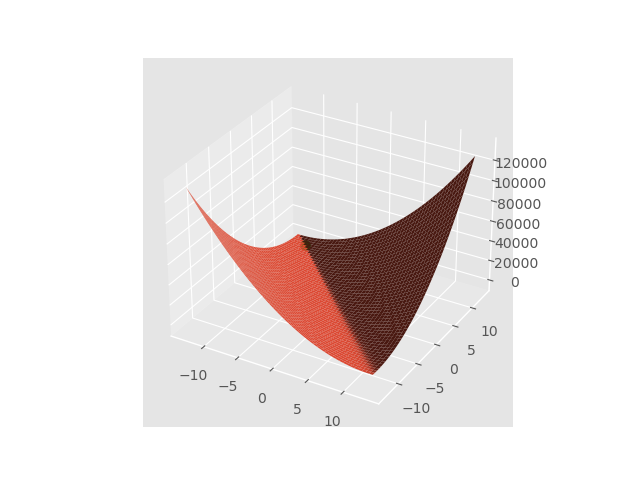

In [309]:
x = np.outer(np.linspace(-13, 13, 1000), np.ones(1000))
y = x.copy().T
z = f((x, y))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(res.x[0], res.x[1], f(res.x), c='green', s=50);
ax.plot_surface(x, y, z);

# 3. Написать скрипты, реализующие методы варианта. Для решения задачи одномерной минимизации использовать метод, признанный лучшим в первой работе. 

Реализация метода Фибонначи для решения задачи одномерной оптимизации:

In [310]:
def fibonacci_numbers(max_value):

    num1, num2 = 1, 1
    
    yield num1
    
    if num1 > max_value and  num2 > max_value:
        return

    if num1 < max_value and num2 > max_value:
        yield num2

    while num2 < max_value:
        num1, num2 = num2, num1 + num2
        yield num2

In [311]:
def fibonacci_method(func, a, b, interval_length, eps, callback=None):
    
    if callback is None:
        callback = lambda c, v: 0
        
    max_value = (b - a) / interval_length
    fib_nums = [num for num in fibonacci_numbers(max_value)]
    length = len(fib_nums) - 1
    y = a + fib_nums[length - 2] / fib_nums[length] * (b - a)
    z = a + fib_nums[length - 1] / fib_nums[length] * (b - a)
    k = 1
    max_k = length - 3
    
    func_y, func_z = func(y), func(z)
    
    for k in range(max_k + 1):        
        if func_y <= func_z:
            less = True
            b, z = z, y
            y = a + fib_nums[length - k - 3] / fib_nums[length - k - 1] * (b - a)
            callback(b, func_z)
        else:
            less = False
            a, y = y, z
            z = a + fib_nums[length - k - 2] / fib_nums[length - k - 1] * (b - a)
            callback(a, func_y)
        func_y, func_z = (func(y), func_y) if less else (func_z, func(z))
        
    y = z
    z = y + eps
    x = (a + z) / 2 if func_y <= func(z) else (y + b) / 2
    callback(x, func(x))
    return x, max_k + 1

## Метод наискорейшего спуска

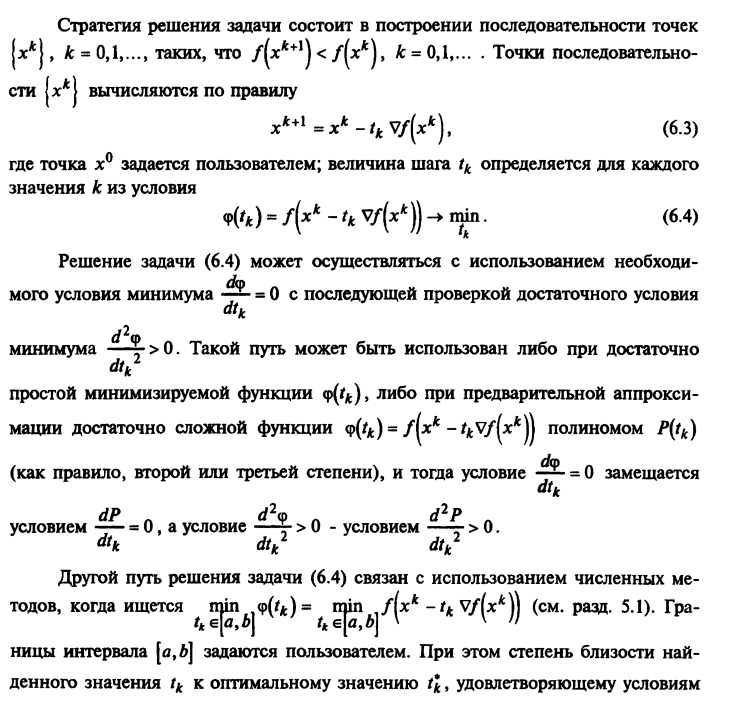
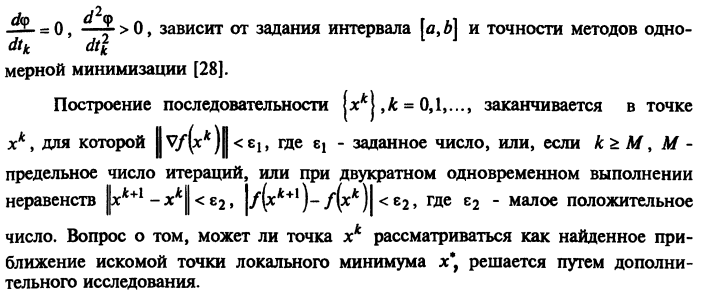

Реализация метода:

In [326]:
def steepest_descent_method(func, gfunc, x, eps,
                          lr_min=1e-7, lr_max=2,
                          n_eps=0.1, max_iter=100_000,
                          callback=None, print_info=False):
    
    if callback is None:
        callback = lambda c, v: 0
    
    def fi(t, x, d):
        nonlocal func
        return func(x + t * d)
    
    fib_k = 0
    
    for k in range(max_iter):
        callback(x, func(x))
        grad = gfunc(x)
        d = - grad
        fi_x_d = partial(fi, x=x, d=d)
        t, fc = fibonacci_method(fi_x_d, lr_min, lr_max, n_eps, n_eps/2)
        fib_k += fc
        t = 0.001
        x_prev = x
        x = x + t * d
        
        if np.linalg.norm(grad) < eps:
            callback(x, func(x))
            print(fib_k)
            return x, k + 1

    if print_info:
        print('Max iterations. Stop')
    callback(x, func(x))
    print(fib_k)
    return x, max_iter

## Метод Марквардта

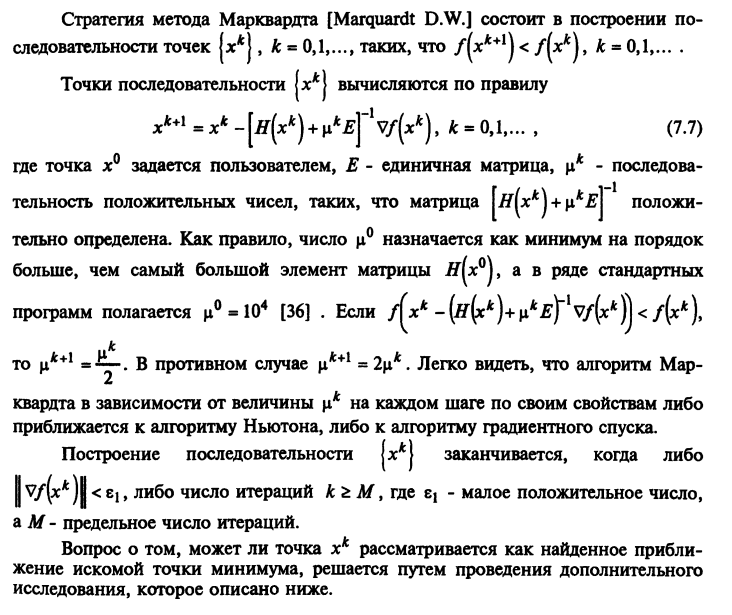

Реализация метода:

In [327]:
def marquardt_method(func, gfunc, hfunc, x, eps, mu=1e4,
                     max_iter=100_000, callback=None, print_info=False):
    
    if callback is None:
        callback = lambda c, v: 0
    func_x_prev = func(x)
        
    for k in range(max_iter):
        
        callback(x, func(x))
        grad = gfunc(x)
        
        if np.linalg.norm(grad) < eps:
            callback(x, func(x))
            return x, k + 1
        
        hesse = hfunc(x)
        d = - np.linalg.inv(hesse + mu * np.eye(2)) @ grad
        x = x + d
        func_x = func(x)
        mu = mu / 2 if func_x < func_x_prev else mu * 2
        func_x_prev = func_x

    if print_info:
        print('Max iterations. Stop')
    callback(x, func(x))
    return x, max_iter

## Метод регулярного симплекса

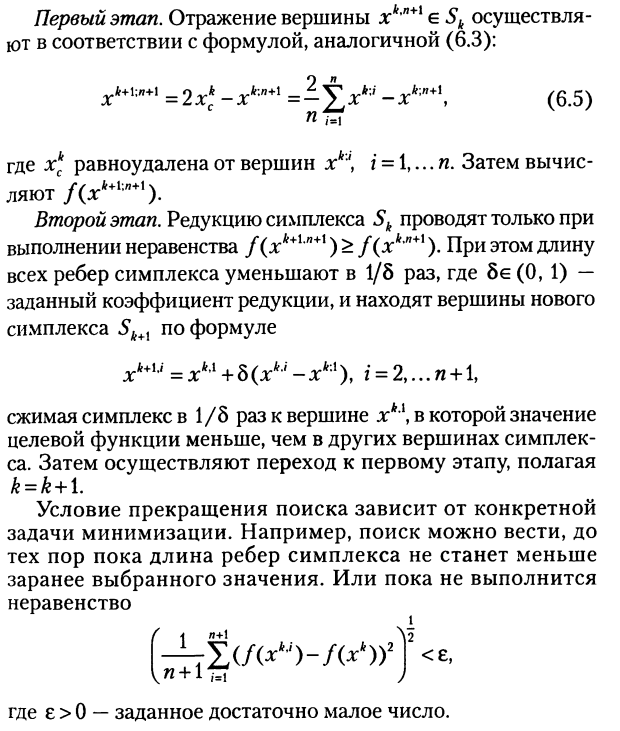

Реализация метода:

In [328]:
def get_simplex(x, length, n=2):
    simplex = np.array([x, np.zeros(2), np.zeros(2)])
    
    for i in range(1, len(simplex)):
        for j in range(n):
            if i == j + 1:
                simplex[i][j] = (simplex[0][j]
                                + (np.sqrt(n + 1) - 1) / (n * np.sqrt(2)) * length)
            else:
                simplex[i][j] = (simplex[0][j]
                                 + (np.sqrt(n + 1) + n - 1) / (n * np.sqrt(2)) * length)
    return simplex

In [329]:
def simplex_reduction(simplex, delta):
    for i in range(1, len(simplex)):
        simplex[i] = simplex[0] + delta * (simplex[i] - simplex[0])
    return simplex

In [330]:
def regular_simplex_method(func, x, length, eps, delta=0.85,
                           n=2, max_iter=100_000, callback=None,
                          print_info=False):
    
    if callback is None:
        callback = lambda c, v: 0
    
    idx_max_f = None
    vect_func = np.vectorize(f, signature="(n)->()")
    simplex = get_simplex(x, length, n)
    func_x = vect_func(simplex)
    callback(x, func(x))
    
    for k in range(max_iter):
        
        if idx_max_f is None:
            idx_max_f = np.argmax(func_x)
            another_idx = [i for i in range(n + 1) if i != idx_max_f]

        cm = np.sum(np.array([simplex[i] for i in range(n + 1) if i != idx_max_f]), axis=0)
        new_vertex = (2 / n * cm - simplex[idx_max_f])
        func_x_new = func(new_vertex)
        
        if func_x_new < func_x[idx_max_f]:
            callback(new_vertex, func(new_vertex))
            func_x_prev = func_x
            func_x[idx_max_f] = func_x_new
            simplex[idx_max_f] = new_vertex
            idx_max_f = None

        else:
            if len(another_idx) == 0:
                simplex = simplex_reduction(simplex, delta)
                length = length * delta
                if length * 2 < eps:
                    return np.mean(simplex, axis=0), k + 1
                idx_max_f = None
            else:
                idx_max_f = another_idx[0]
                another_idx = [idx for idx in another_idx if idx != another_idx[0]]
            
        
    if print_info:
        print('Max iterations. Stop')
    callback(np.mean(simplex, axis=0), func(x))
    return np.mean(simplex, axis=0), max_iter

## Метод наилучшей пробы 

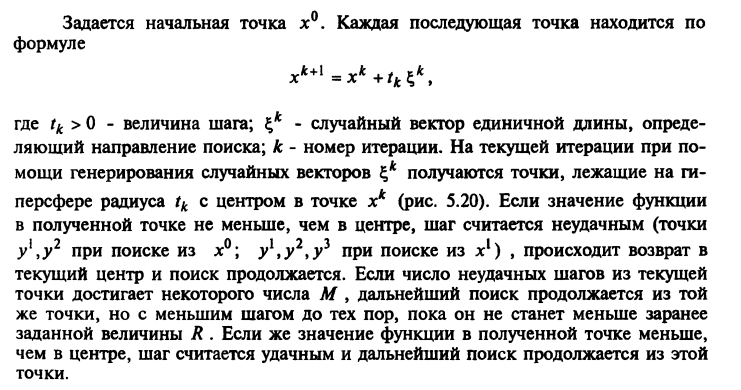

Реализация метода:

In [331]:
def best_test_method(func, x, min_lr, betta=0.3, m=20,
                     lr=1, max_iter=100_000,
                     callback=None, print_info=False):
    
    if callback is None:
        callback = lambda c, v: 0
    
    vect_func = np.vectorize(func, signature="(n)->()")
    
    for k in range(max_iter):
        np.random.seed(k)
        vectors = np.random.uniform(-1, 1, size=(m, 2))
        vectors = vectors / np.linalg.norm(vectors, axis=1)[..., None]
        y = x + lr * vectors
        func_y = vect_func(y)
        idx_min_func = np.argmin(func_y)
        if func_y[idx_min_func] < func(x):
            x = y[idx_min_func]
            callback(x, func(x))
        else:
            lr = lr * betta
            if lr < min_lr:
                return x, k + 1
            
    return x, max_iter

# 4. Сделать визуализацию для каждого метода, совместив на одном графике линии уровня и последовательность приближений к решению. 

<IPython.core.display.Javascript object>


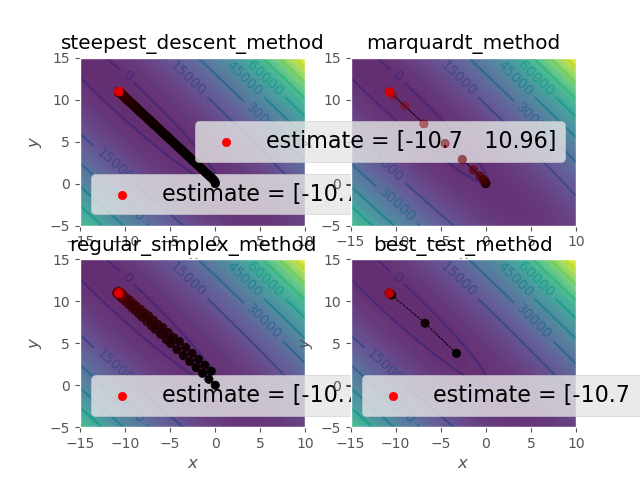

5548


Text(0.5, 1.0, 'best_test_method')

In [332]:
fig, ax = plt.subplots(2, 2)

callback = LoggingCallback()
sdx, sdk = steepest_descent_method(f, grad_f, x0, tol, callback=callback)
plot_convergence_2d(np.vectorize(f, signature="(n)->()"),
                    np.vstack(callback.x_steps),
                    ax=ax[0, 0],
                    xlim=(-15, 10),
                    ylim=(-5, 15),
                   )
ax[0, 0].set_title('steepest_descent_method')

callback = LoggingCallback()
mx, mk = marquardt_method(f, grad_f, hesse_f, x0, tol, callback=callback)
plot_convergence_2d(np.vectorize(f, signature="(n)->()"),
                    np.vstack(callback.x_steps),
                    ax=ax[0, 1],
                    xlim=(-15, 10),
                    ylim=(-5, 15),
                   )
ax[0, 1].set_title('marquardt_method')

callback = LoggingCallback()
rsx, rsk = regular_simplex_method(f, x0, 1, tol, callback=callback)
plot_convergence_2d(np.vectorize(f, signature="(n)->()"),
                    np.vstack(callback.x_steps),
                    ax=ax[1, 0],
                    xlim=(-15, 10),
                    ylim=(-5, 15),
                   )
ax[1, 0].set_title('regular_simplex_method')

callback = LoggingCallback()
btx, btk = best_test_method(f, x0, tol, lr=5, callback=callback)
plot_convergence_2d(np.vectorize(f, signature="(n)->()"),
                    np.vstack(callback.x_steps),
                    ax=ax[1, 1],
                    xlim=(-15, 10),
                    ylim=(-5, 15),
                   )
ax[1, 1].set_title('best_test_method')

Результаты:

In [333]:
results = {
    'method': ['steepest_descent_method', 'marquardt_method', 'regular_simplex_method', 'best_test_method'],
    'iterations': [sdk, mk, rsk, btk],
    'func_evals': [sdk + 18031, mk + 1, rsk, 21*btk],
    'grad_evals': [sdk, mk, 0, 0],
    'hesse_eval': [0, mk, 0, 0],
    '[x1, x2]': [np.round(sdx, 3), np.round(mx, 3), np.round(rsx, 3), np.round(btx, 3)],
    'f(x)': [np.round(f(sdx), 3), np.round(f(mx), 3), np.round(f(rsx), 3), np.round(f(btx), 3)],
    '||x - x*|| < eps': [np.linalg.norm(sdx - res.x) < tol, np.linalg.norm(mx - res.x) < tol,
                        np.linalg.norm(rsx - res.x) < tol, np.linalg.norm(btx - res.x)  < tol]
    
}
pd.DataFrame(results)

,method,iterations,func_evals,grad_evals,hesse_eval,"[x1, x2]",f(x),||x - x*|| < eps
0,steepest_descent_method,1387,19418,1387,0,"[-10.704, 10.963]",-1417.162,True
1,marquardt_method,18,19,18,18,"[-10.704, 10.963]",-1417.162,True
2,regular_simplex_method,430,430,0,0,"[-10.704, 10.963]",-1417.162,True
3,best_test_method,31,651,0,0,"[-10.704, 10.963]",-1417.162,True


# 5. Найти минимум функции Розенброка 

Начальная точка и требуемая точность:

In [295]:
x0 = np.array([-1, 1])
tol = 1e-5

Заданная функция:

In [296]:
def f(x):
    return 100 * (x[0]**2 - x[1])**2 + (x[0] - 1)**2

Градиент функции:

In [297]:
def grad_f(x):
    dfdx = 400 * x[0]**3 - 400 * x[0] * x[1] + 2 * x[0] - 2
    dfdy = -200 * x[0] ** 2 + 200 * x[1]
    return np.array([dfdx, dfdy])

Матрица Гессе заданной функции:

In [298]:
def hesse_f(x, inv=False):
    d2fdx2 = 1200 * x[0] ** 2 - 400 * x[1] + 2
    d2fdxdy = - 400 * x[0]
    hessian = np.array([[d2fdx2, d2fdxdy],
                        [d2fdxdy, 200]])
    if not inv:
        return hessian
    else:
        return np.linalg.inv(hessian)

Нахождение минимумма втроенным методом:

In [299]:
res = minimize(f, x0, method='Nelder-Mead',
               options={'xatol': 1e-8, 'disp': True})
print(f'min x: {res.x}, f(x) = {f(res.x)}')

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 130
         Function evaluations: 244
min x: [1. 1.], f(x) = 5.466578007688685e-18


Визуализация функции и её минимума:

<IPython.core.display.Javascript object>


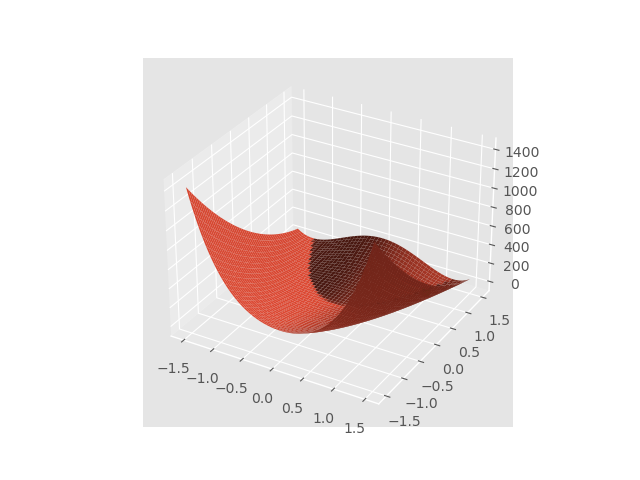

In [300]:
x = np.outer(np.linspace(-1.5, 1.5, 1000), np.ones(1000))
y = x.copy().T
z = f((x, y))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(res.x[0], res.x[1], f(res.x), c='green', s=50);
ax.plot_surface(x, y, z);

Визуализация нахождения миниумма функции:

<IPython.core.display.Javascript object>


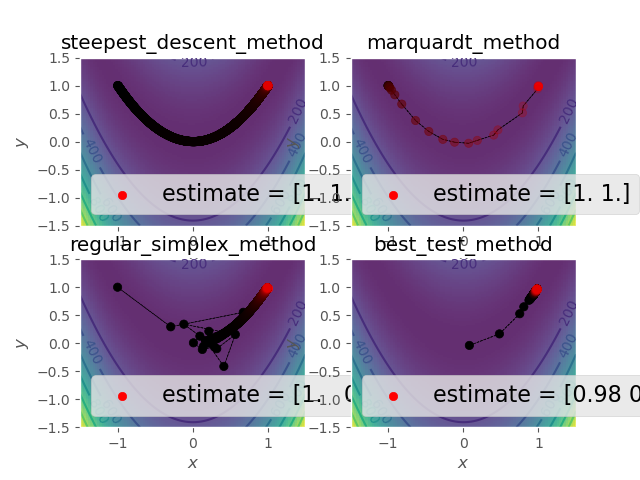

341536


Text(0.5, 1.0, 'best_test_method')

In [301]:
fig, ax = plt.subplots(2, 2)

callback = LoggingCallback()
sdx, sdk = steepest_descent_method(f, grad_f, x0, tol, callback=callback)
plot_convergence_2d(np.vectorize(f, signature="(n)->()"),
                    np.vstack(callback.x_steps),
                    ax=ax[0, 0],
                    xlim=(-1.5, 1.5),
                    ylim=(-1.5, 1.5),
                   )
ax[0, 0].set_title('steepest_descent_method')

callback = LoggingCallback()
mx, mk = marquardt_method(f, grad_f, hesse_f, x0, tol, callback=callback)
plot_convergence_2d(np.vectorize(f, signature="(n)->()"),
                    np.vstack(callback.x_steps),
                    ax=ax[0, 1],
                    xlim=(-1.5, 1.5),
                    ylim=(-1.5, 1.5),
                   )
ax[0, 1].set_title('marquardt_method')

callback = LoggingCallback()
rsx, rsk = regular_simplex_method(f, x0, 1, tol, callback=callback)
plot_convergence_2d(np.vectorize(f, signature="(n)->()"),
                    np.vstack(callback.x_steps),
                    ax=ax[1, 0],
                    xlim=(-1.5, 1.5),
                    ylim=(-1.5, 1.5),
                   )
ax[1, 0].set_title('regular_simplex_method')

callback = LoggingCallback()
btx, btk = best_test_method(f, x0, tol, lr=5, callback=callback)
plot_convergence_2d(np.vectorize(f, signature="(n)->()"),
                    np.vstack(callback.x_steps),
                    ax=ax[1, 1],
                    xlim=(-1.5, 1.5),
                    ylim=(-1.5, 1.5),
                   )
ax[1, 1].set_title('best_test_method')

In [302]:
results = {
    'method': ['steepest_descent_method', 'marquardt_method', 'regular_simplex_method', 'best_test_method'],
    'iterations': [sdk + 40000, mk, rsk, btk],
    'func_evals': [sdk, mk + 1, rsk, 21*btk],
    'grad_evals': [sdk, mk, 0, 0],
    'hesse_eval': [0, mk, 0, 0],
    '[x1, x2]': [np.round(sdx, 3), np.round(mx, 3), np.round(rsx, 3), np.round(btx, 3)],
    'f(x)': [np.round(f(sdx), 3), np.round(f(mx), 3), np.round(f(rsx), 3), np.round(f(btx), 3)],
    '||x - x*|| < eps': [np.linalg.norm(sdx - res.x) < tol, np.linalg.norm(mx - res.x) < tol,
                        np.linalg.norm(rsx - res.x) < tol, np.linalg.norm(btx - res.x)  < tol]
    
}
pd.DataFrame(results)

,method,iterations,func_evals,grad_evals,hesse_eval,"[x1, x2]",f(x),||x - x*|| < eps
0,steepest_descent_method,66272,26272,26272,0,"[1.0, 1.0]",0.0,False
1,marquardt_method,27,28,27,27,"[1.0, 1.0]",0.0,True
2,regular_simplex_method,9780,9780,0,0,"[0.996, 0.991]",0.0,False
3,best_test_method,2689,56469,0,0,"[0.984, 0.968]",0.0,False


# 6. Результаты вычислений свести в таблицу с добавлением информации о количестве итераций, количестве вычислений функции и производной. Сформулировать выводы об эффективности методов и их применимости. 


Табицы с информацией о нахождении минимума функций представлены выше.

Метод наискорейшего спуска является достаточно универсальным, так как требует знание только функции и её градиента, найти которые не так сложно. Конечно, скорость нахождения минимума является достаточно низкой, но если выполнить достаточно много итераций, то нахождение минимума возможно.

Метод Марквардта является самым эффективным, но при этом требует знание функции, её градиента и матрицы Гессе. В отличие от метода Ньютона, он не имеет свойства притягиваться к максимумам, но при этом выполняет немного итераций и вычислений функции.

Метод регулярного симплекса использует знания только о функции, но при этом из-за использования симплекса (особенно из-за его формы), использование этого метода для нахождения минимума, находящегося в "каньонах" функции является затруднительным. При этом методы выполняет относительно немного итераций и вычислений функции, но подбор гиперпараметров является затруднительным.

Метод наилучшей пробы является наиболее ресурсозатратным, но при этом его реализация не является затруднительной. Нахождение минимума зависит от воли случая, но при большом очень количестве итераций и использовании большого количества случайных векторов, является возможной. 